# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [6]:
DATA_PATH = './data'
QUOTATION = 'AAPL'
FILE_SUFFIX = '.txt'

In [7]:
PREDICT_N = 1

In [8]:
price_column='Close'
df, feature_names = features_pipeline(f"{DATA_PATH}/{QUOTATION}{FILE_SUFFIX}", predict_n=PREDICT_N,
    price_column=PRICE_COLUMN, normalize_features=True)

df.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Difference,PercentageDiff,Tendency,MA(10),MA(20) - MA(10),RSI(14),GAP,RSI_Diff,Volume_diff,Next,MACD,MACD_diff,MACD_signal
34,2007-02-21,3.070714,3.196071,3.070000,3.185714,1.155314e+09,2.748159,0.016097,0.015462,higher,-0.995389,0.060756,-0.041247,-0.145541,-0.241403,0.063978,higher,-0.225796,0.233739,-0.277960
35,2007-02-22,3.242857,3.243214,3.161786,3.196786,8.382248e+08,2.757710,0.020467,0.098997,higher,-0.995448,0.061799,-0.084577,-0.144632,-0.020057,0.003490,lower,-0.226989,0.231798,-0.278582
36,2007-02-23,3.184286,3.226429,3.173214,3.181072,5.178936e+08,2.744154,0.015090,-0.006782,lower,-0.995643,0.063668,-0.274763,-0.141265,-0.233123,-0.026715,lower,-0.228913,0.228488,-0.279518
37,2007-02-26,3.208571,3.214286,3.128929,3.161072,6.158488e+08,2.726901,0.025983,0.209021,lower,-0.995726,0.064834,-0.147243,-0.148635,0.227823,-0.145231,lower,-0.229920,0.228046,-0.280495
38,2007-02-27,3.082143,3.110000,2.978929,2.997500,1.145813e+09,2.585796,0.018109,0.051914,lower,-0.995910,0.066249,-0.246158,-0.149727,-0.100703,0.027462,higher,-0.231257,0.226896,-0.281582


### Plots

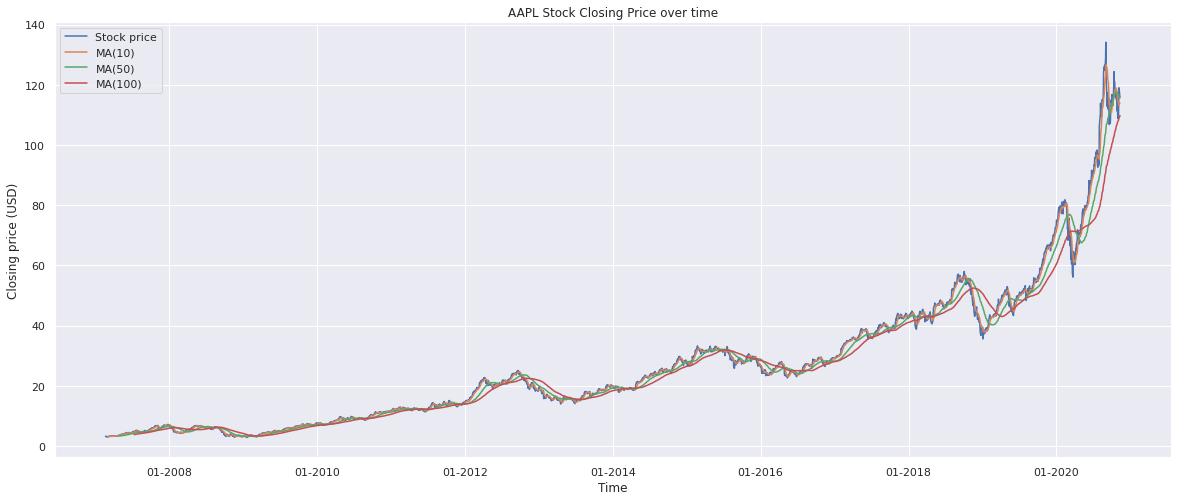

In [9]:
import datetime
import matplotlib.dates as mdates

N_YEARS = 50
values = df.tail(365*N_YEARS)[price_column]

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*N_YEARS).Date]
ax = plt.gca()
ax.set(title=f"{QUOTATION} Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Plot histogram differences

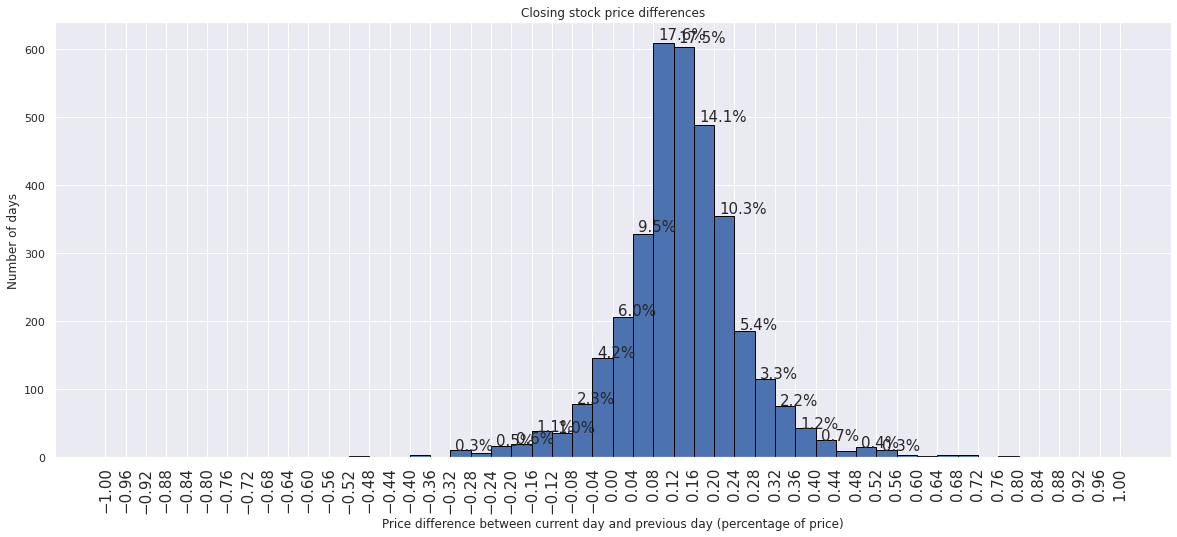

In [10]:
import matplotlib.ticker as mtick

def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)
        
values = df['PercentageDiff']
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences")
plt.xlabel('Price difference between current day and previous day (percentage of price)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

### ML Data preparation

In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Difference,PercentageDiff,Tendency,MA(10),MA(20) - MA(10),RSI(14),GAP,RSI_Diff,Volume_diff,Next,MACD,MACD_diff,MACD_signal
34,2007-02-21,3.070714,3.196071,3.070000,3.185714,1.155314e+09,2.748159,0.016097,0.015462,higher,-0.995389,0.060756,-0.041247,-0.145541,-0.241403,0.063978,higher,-0.225796,0.233739,-0.277960
35,2007-02-22,3.242857,3.243214,3.161786,3.196786,8.382248e+08,2.757710,0.020467,0.098997,higher,-0.995448,0.061799,-0.084577,-0.144632,-0.020057,0.003490,lower,-0.226989,0.231798,-0.278582
36,2007-02-23,3.184286,3.226429,3.173214,3.181072,5.178936e+08,2.744154,0.015090,-0.006782,lower,-0.995643,0.063668,-0.274763,-0.141265,-0.233123,-0.026715,lower,-0.228913,0.228488,-0.279518
37,2007-02-26,3.208571,3.214286,3.128929,3.161072,6.158488e+08,2.726901,0.025983,0.209021,lower,-0.995726,0.064834,-0.147243,-0.148635,0.227823,-0.145231,lower,-0.229920,0.228046,-0.280495
38,2007-02-27,3.082143,3.110000,2.978929,2.997500,1.145813e+09,2.585796,0.018109,0.051914,lower,-0.995910,0.066249,-0.246158,-0.149727,-0.100703,0.027462,higher,-0.231257,0.226896,-0.281582


In [12]:
print(feature_names)

['Difference', 'PercentageDiff', 'Tendency', 'MA(10)', 'MA(20) - MA(10)', 'RSI(14)', 'GAP', 'RSI_Diff', 'Volume_diff', 'Next', 'MACD', 'MACD_diff', 'MACD_signal']


In [13]:
dataset = df.copy()

dataset = df.loc[:, feature_names]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])
for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':-1})

dataset.head()

,Difference,PercentageDiff,Tendency,MA(10),MA(20) - MA(10),RSI(14),GAP,RSI_Diff,Volume_diff,Next,MACD,MACD_diff,MACD_signal
34,0.016097,0.015462,1,-0.995389,0.060756,-0.041247,-0.145541,-0.241403,0.063978,1,-0.225796,0.233739,-0.277960
35,0.020467,0.098997,1,-0.995448,0.061799,-0.084577,-0.144632,-0.020057,0.003490,-1,-0.226989,0.231798,-0.278582
36,0.015090,-0.006782,-1,-0.995643,0.063668,-0.274763,-0.141265,-0.233123,-0.026715,-1,-0.228913,0.228488,-0.279518
37,0.025983,0.209021,-1,-0.995726,0.064834,-0.147243,-0.148635,0.227823,-0.145231,-1,-0.229920,0.228046,-0.280495
38,0.018109,0.051914,-1,-0.995910,0.066249,-0.246158,-0.149727,-0.100703,0.027462,1,-0.231257,0.226896,-0.281582


### Dataset class balance

<AxesSubplot:>

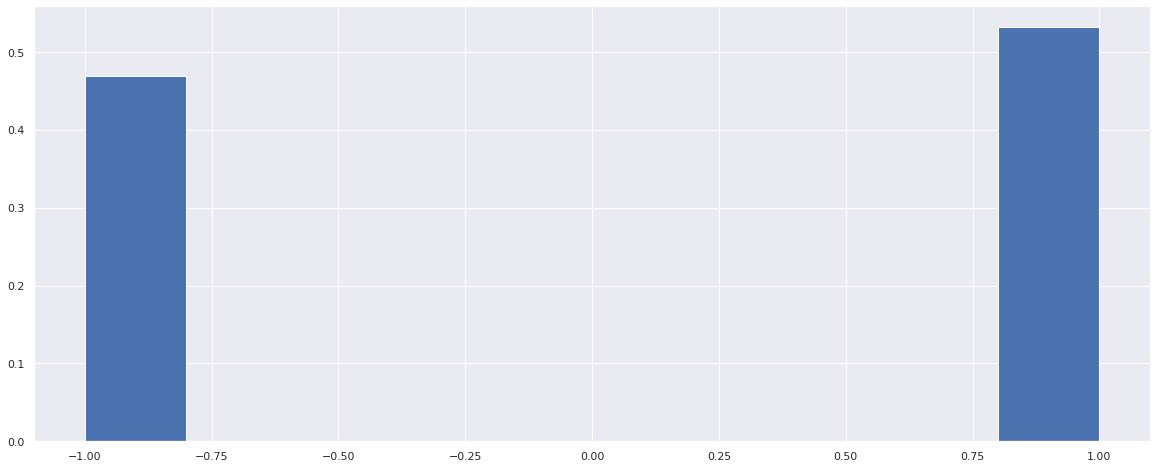

In [14]:
# plot normalized histogram
dataset['Next'].hist(weights = np.ones_like(dataset.Next) / len(dataset.Next))

### Train / Test data 

In [15]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [16]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 2419, test size : 1038 (30%)


## Classifier and evaluation

In [17]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

{-1: 1.0676343421865349, 1: 0.940424374319913}


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[-1  1], y=34      1
35     -1
36     -1
37     -1
38      1
       ..
3486    1
3487   -1
3488   -1
3489   -1
3490    1
Name: Next, Length: 3457, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10}, 'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}, 'SVM': {'gamma': 'auto'}, 'LR': {'penalty': 'l2', 'C': 1.0}}
param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [27]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


[DTree] Accuracy : 0.53, F1 : 0.53
[RandomForest] Accuracy : 0.53, F1 : 0.53
[SVM] Accuracy : 0.51, F1 : 0.52
[LR] Accuracy : 0.53, F1 : 0.53


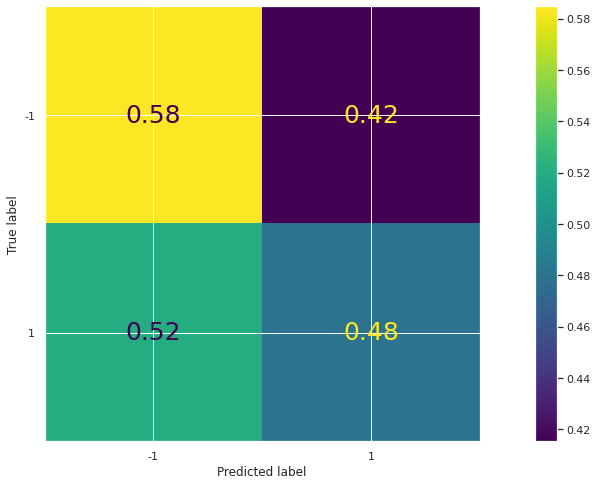

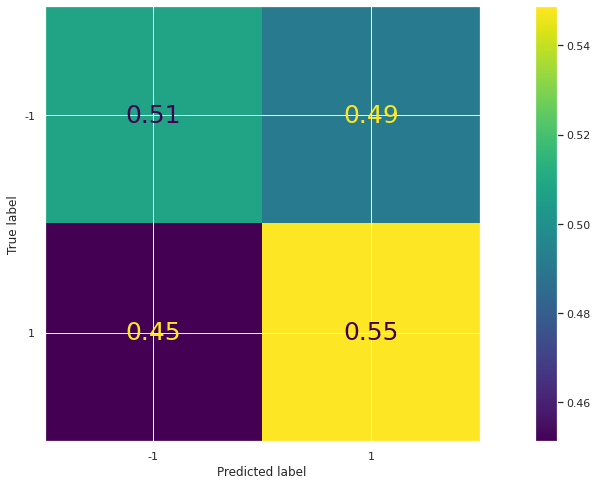

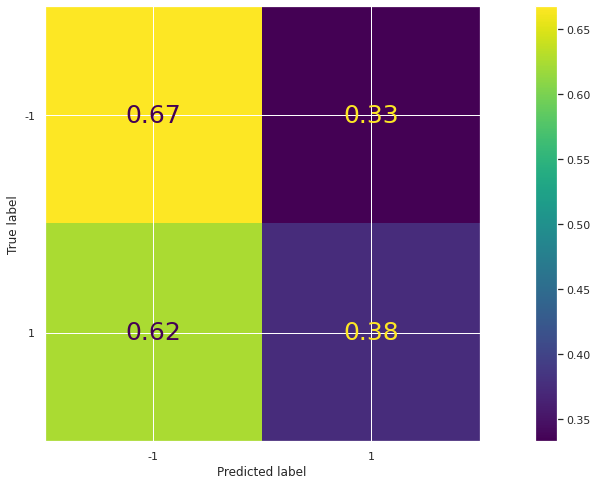

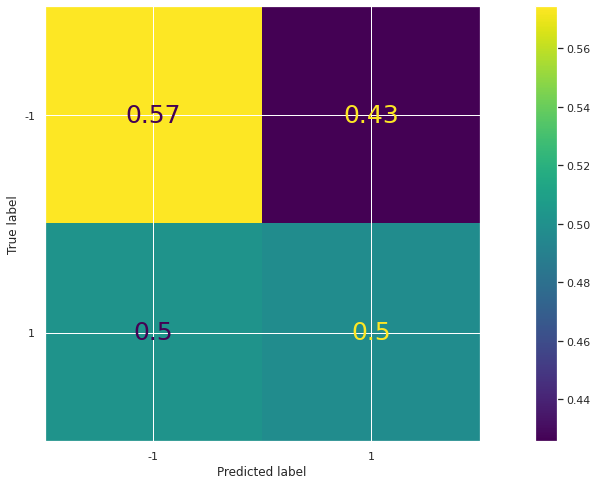

In [28]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

|--- MACD_diff <= 0.26
|   |--- MACD_signal <= -0.29
|   |   |--- class: -1
|   |--- MACD_signal >  -0.29
|   |   |--- class: 1
|--- MACD_diff >  0.26
|   |--- MACD_diff <= 0.26
|   |   |--- class: -1
|   |--- MACD_diff >  0.26
|   |   |--- class: -1



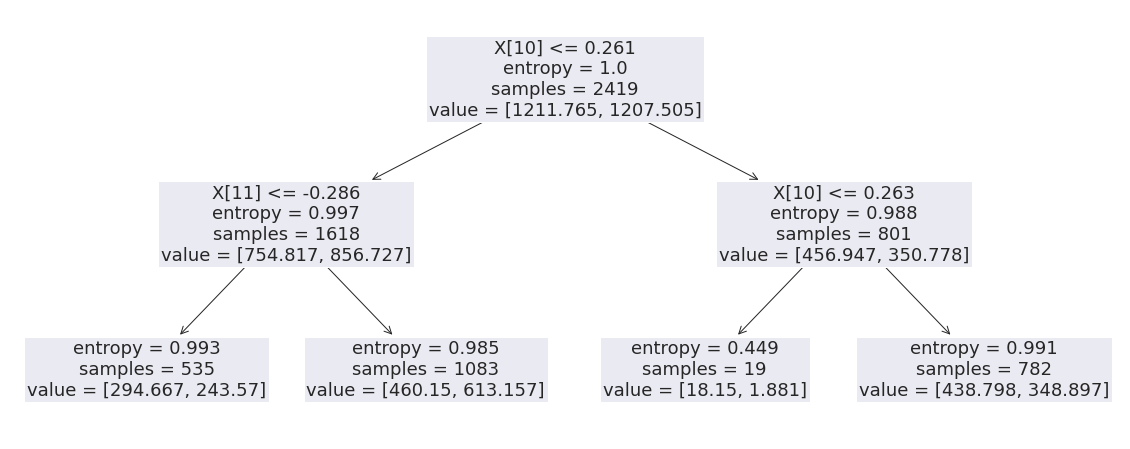

In [29]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)

In [23]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std


data_columns = ['Volume', 'Volume_diff', 'PercentageDiff', 'Next']
dataset = df.copy()
dataset = df.loc[:, data_columns]
print(dataset.head())
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']


model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

          Volume  Volume_diff  PercentageDiff    Next
34  1.155314e+09     0.063978        0.015462  higher
35  8.382248e+08     0.003490        0.098997   lower
36  5.178936e+08    -0.026715       -0.006782   lower
37  6.158488e+08    -0.145231        0.209021   lower
38  1.145813e+09     0.027462        0.051914  higher
Accuracy: 0.505 (0.023)


In [ ]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)

print(X.shape)
print(selected.shape)